In [1]:
import pandas as pd
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Get data

data = pd.read_csv("fifa21_male2.csv")

In [3]:
# Have data frame

df = data.copy()
df.shape # df has 17125 rows, 107 columns

(17125, 107)

In [4]:
# Standardize the names of columns
df.columns = [df.columns[i].replace(' ', '_') for i in range(len(df.columns))] # I didn't make them lowercases because of the abbreviations, I find it easier to read using uppercases

# df.head()

### Separate numerical/categorical type

In [5]:
# Get the numeric data into dataframe called numerical 
numerical = df.select_dtypes(include="number")

# Get the categorical columns in a dataframe called categorical
categorical = df.select_dtypes(include="object")  


In [6]:
# drop irrelavant columns, that will not be used in analysis
# I keep only "BP", "Position" for now

cat = categorical[["BP", "Position", ]]
cat.head()

,BP,Position
0,LWB,LM
1,CM,CM CAM CDM
2,CAM,CAM RM RW LM
3,ST,NaN
4,CAM,CM CAM


In [7]:
# get numerical columns and change values from string to integer

num = categorical[[
    "Height", "Weight", "Value", "Wage", "Release_Clause", "Hits"]]
num.head()

,Height,Weight,Value,Wage,Release_Clause,Hits
0,"6'0""",181lbs,€625K,€7K,€0,4
1,"5'10""",143lbs,€600K,€7K,€1.1M,4
2,"5'9""",161lbs,€1.1M,€15K,€0,11
3,"5'11""",165lbs,€0,€0,€0,3
4,"5'7""",150lbs,€5.5M,€12K,€7.2M,149


In [8]:
# Convert Hits into the correct format & into integer
num['Hits'] = num['Hits'].replace("K","e+03", regex=True).astype(float).astype(int) # script by Andre

In [9]:
# change value to integer
def money_col(col_name):
    num[col_name] = num[col_name].replace({'€': '', ' ': '', 'M': 'e+06', 'K': 'e+03'}, regex=True).astype(float).astype(int) # script by Andre
    
money_col("Value")
money_col("Wage")
money_col("Release_Clause")

In [10]:
# Converting pounds to kg
num["Weight"] = num["Weight"].replace("lbs$", "", regex=True)
num["Weight"] = round(num["Weight"].astype(float)*0.454, 2)

# Converting Height (feets) to centimeters
# Remove ' " ' , the inche
num["Height"] = num["Height"].replace('"', '', regex=True)

# Splitting Feet from Inches
num["Height_split"] = num["Height"].str.split("'")


# Get feet and inch, put them into separate columns
num["feet"] = num["Height_split"].str.get(0).astype(float) # get feet from position 0
num["inch"] = num["Height_split"].str.get(1).astype(float)# get inch from position 0

# Calculate the value into the Height column
num["Height"] = (num["feet"]*12 + num["inch"])*2.54


In [11]:
# Remove unwanted column from num
num = num.drop(["feet", "inch", "Height_split"], axis=1)

# check all the updated values
num.head()

,Height,Weight,Value,Wage,Release_Clause,Hits
0,182.88,82.17,625000,7000,0,4
1,177.80,64.92,600000,7000,1100000,4
2,175.26,73.09,1100000,15000,0,11
3,180.34,74.91,0,0,0,3
4,170.18,68.10,5500000,12000,7200000,149


In [12]:
# concat numerical data into one data frame
num = pd.concat([numerical, num], axis=1)

In [13]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                17125 non-null  int64  
 1   Age               17125 non-null  int64  
 2   OVA               17125 non-null  int64  
 3   BOV               17125 non-null  int64  
 4   POT               17125 non-null  int64  
 5   Growth            17125 non-null  int64  
 6   Attacking         17125 non-null  int64  
 7   Crossing          17125 non-null  int64  
 8   Finishing         17125 non-null  int64  
 9   Heading_Accuracy  17125 non-null  int64  
 10  Short_Passing     17125 non-null  int64  
 11  Volleys           17067 non-null  float64
 12  Skill             17125 non-null  int64  
 13  Dribbling         17125 non-null  int64  
 14  Curve             17067 non-null  float64
 15  FK_Accuracy       17125 non-null  int64  
 16  Long_Passing      17125 non-null  int64 

In [14]:
# keep all num columns to num_fifa, for compiling to_csv later --> we'll need for SQL query
num_fifa = num.copy()

In [15]:
# drop id column
num = num.drop(["ID"], axis=1)

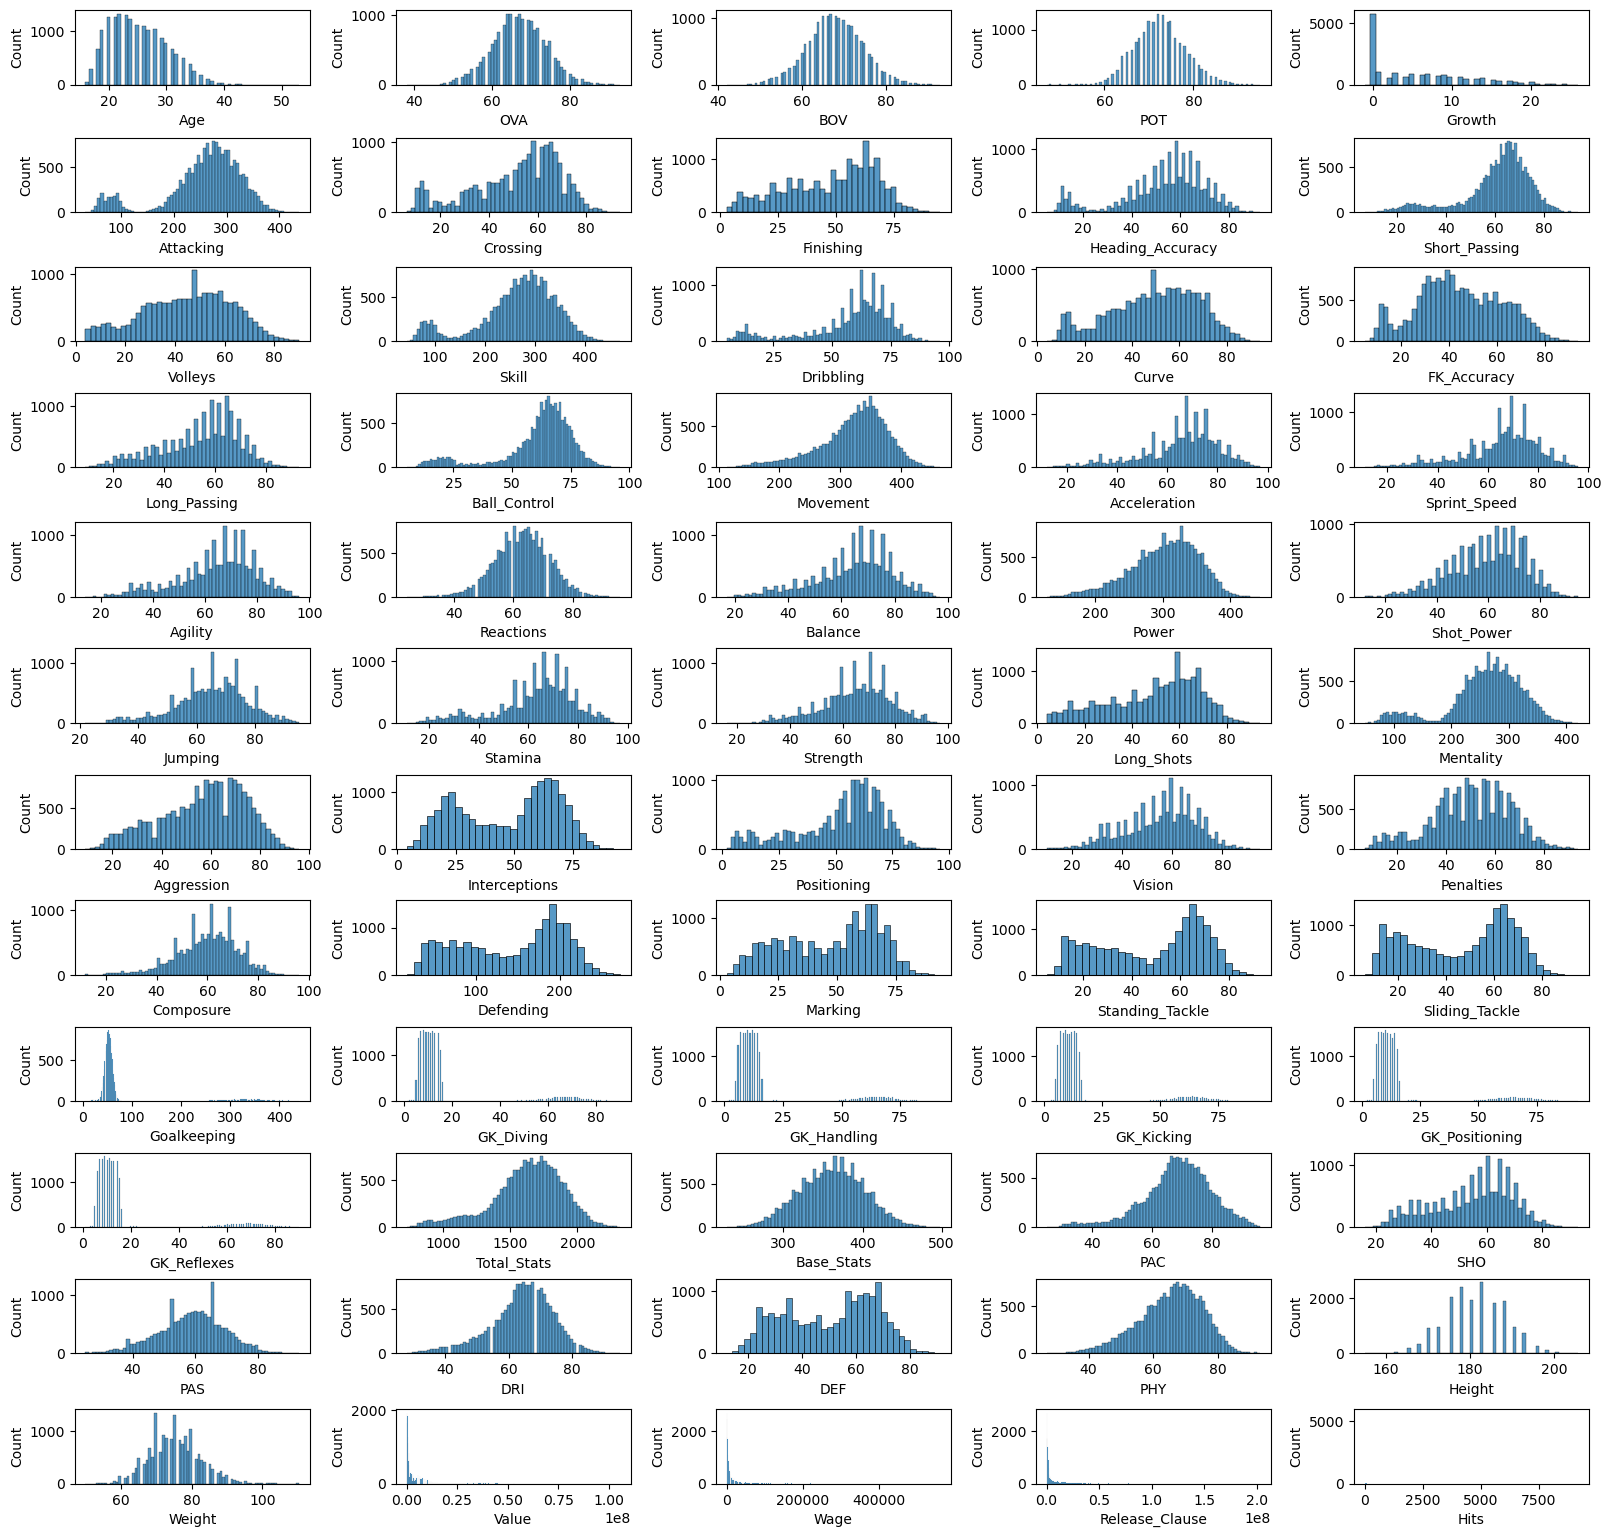

In [16]:
def distribution_check():
    enumerate(num, start = 1) 
    a = list(enumerate(num, start = 1)) 

    plt.figure(figsize = (16, 16), constrained_layout=True)

    for i in a:
        plt.subplot(13, 5, i[0]) # create multi-plot, using subplot, 13 rows, 5 cols, sequence of plot (iterate through "a")
        sns.histplot(data = num, x = i[1])

distribution_check()

## Check Multicolinearity

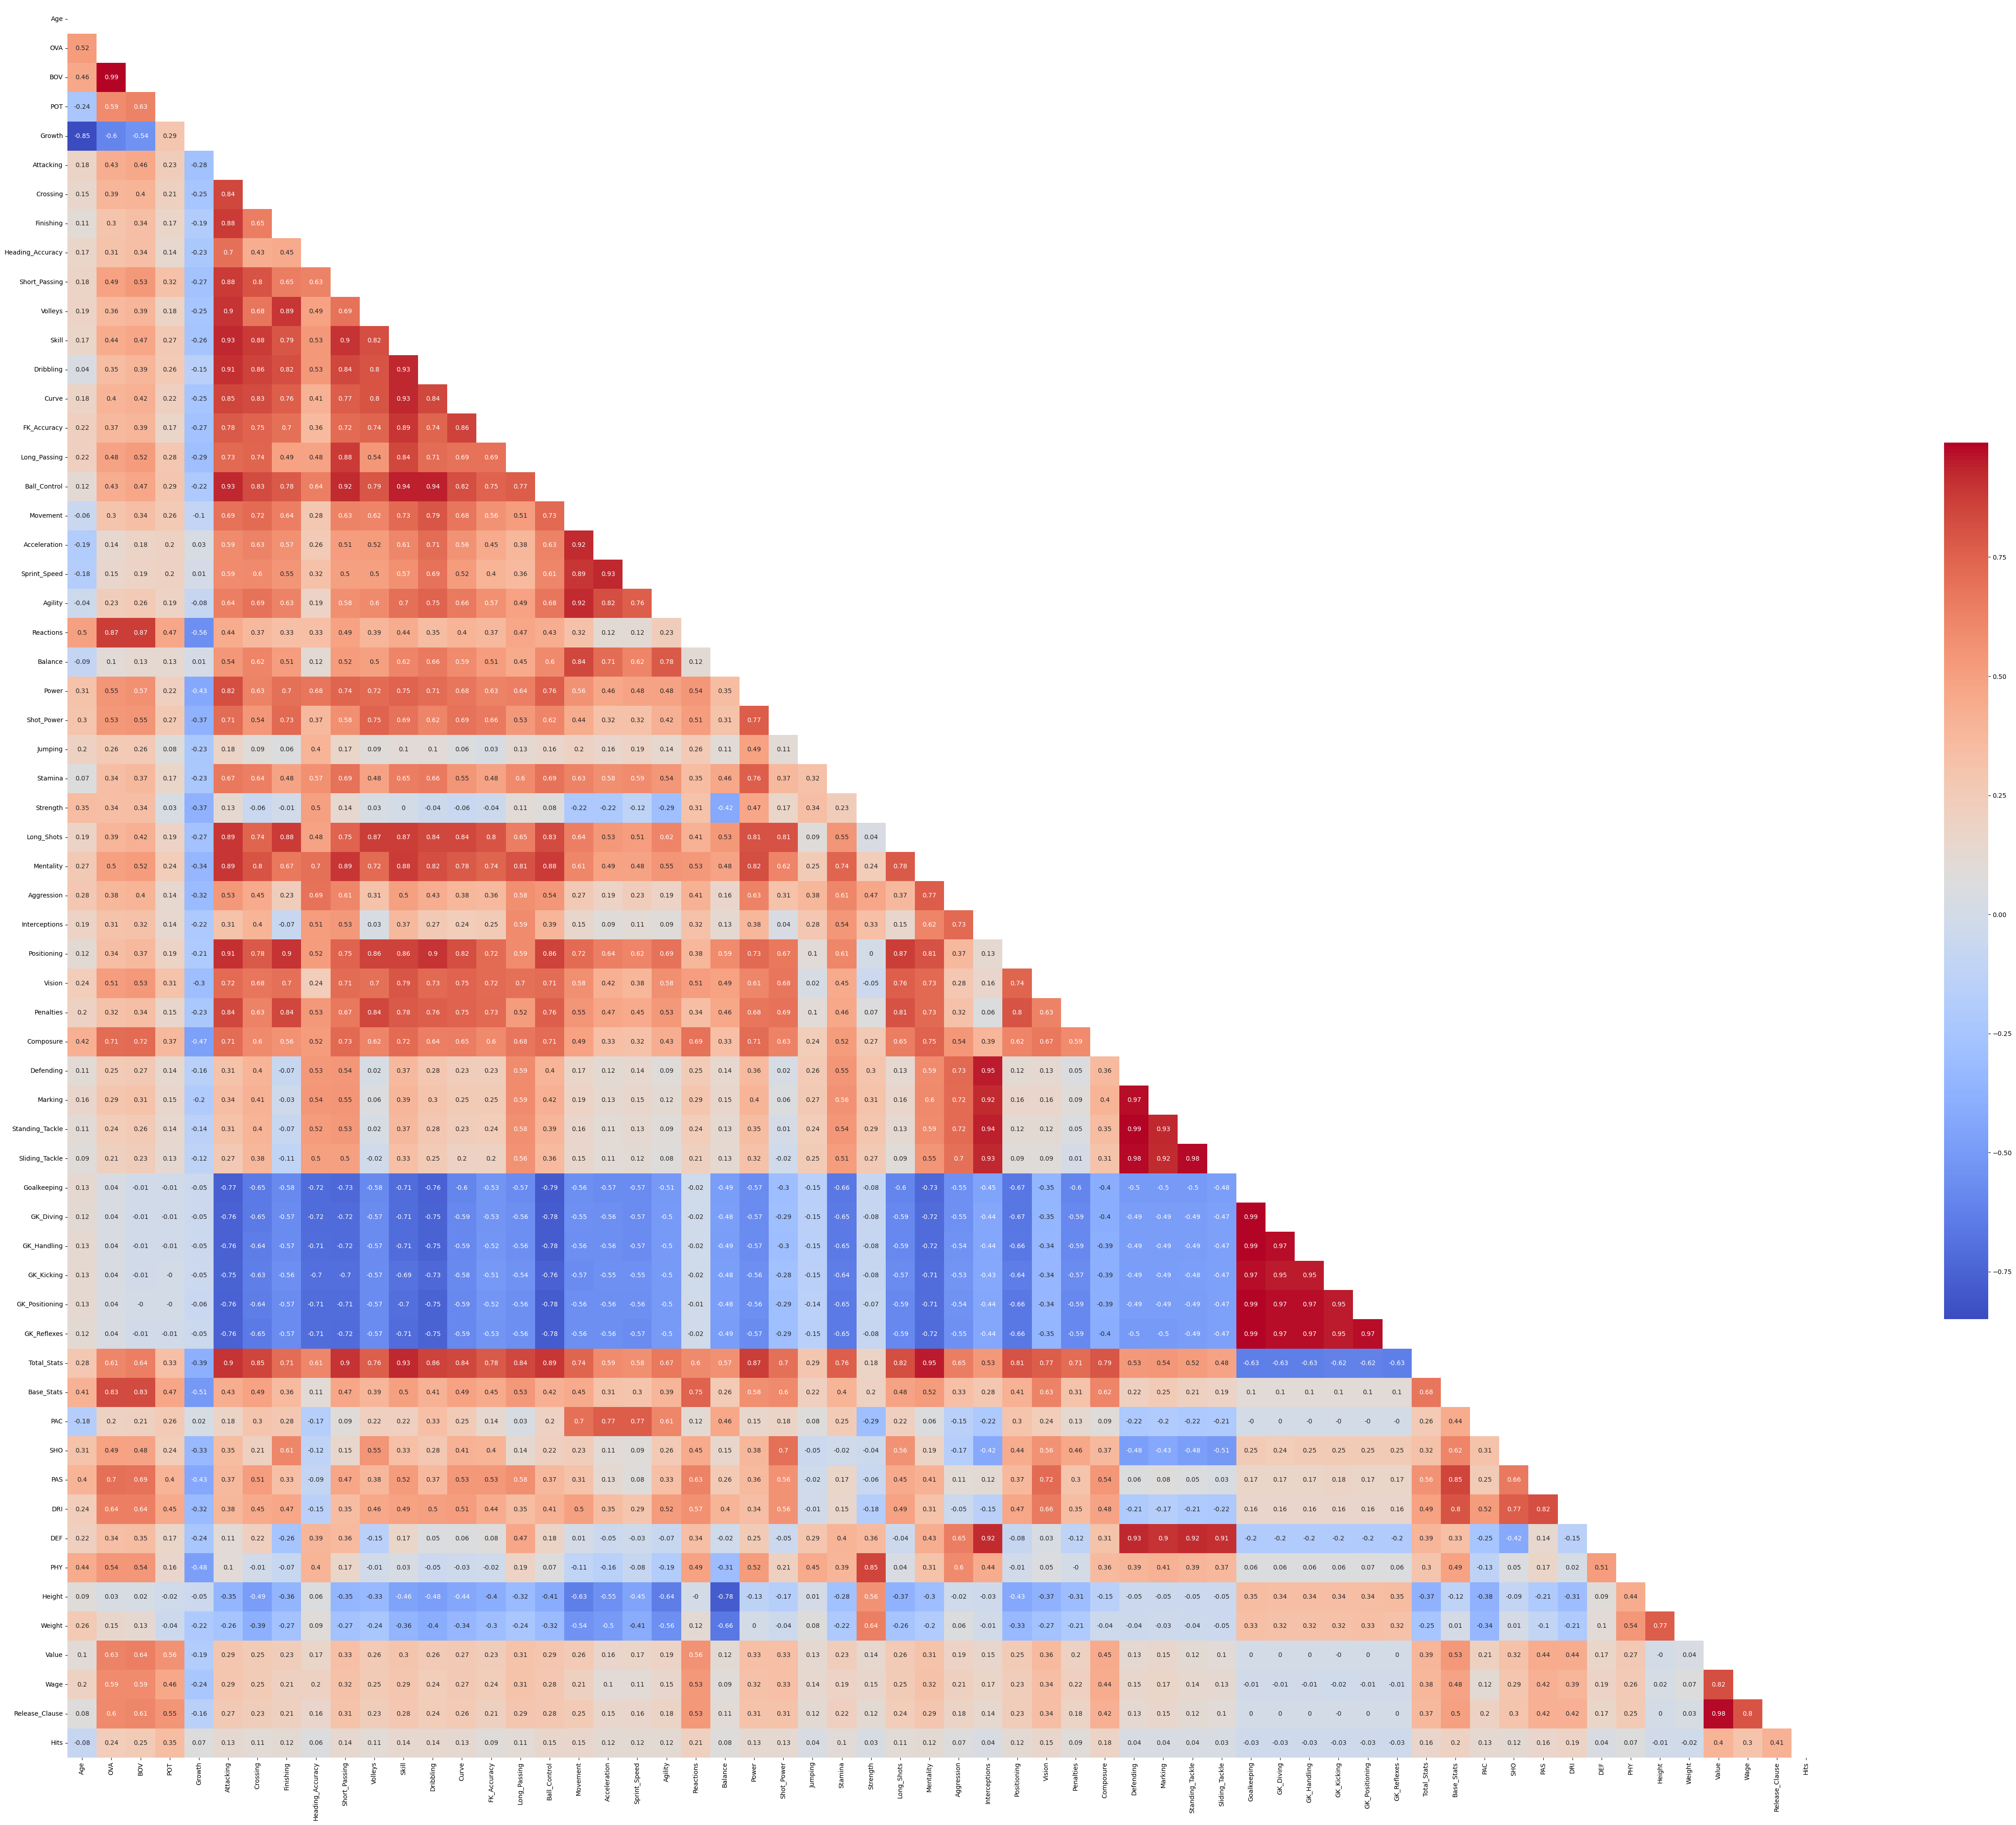

In [17]:
# For the numerical variables, check the multicollinearity between the features. 

data_corr = num.corr()
correlations_matrix = round(data_corr,2)

mask = np.zeros_like(correlations_matrix)

mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(70, 50))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True, square=True, cbar_kws={"shrink":.5}, cmap='coolwarm')


In [18]:
# drop multicolinearity & irrelavant columns
num = num.drop(["OVA", "GK_Diving", "GK_Handling", "GK_Kicking", "GK_Positioning", "GK_Reflexes", 
                "Short_Passing", "Heading_Accuracy", "Curve", "Ball_Control","Dribbling", "Acceleration", 
                "Sprint_Speed", "Agility","Defending", "Marking", "Standing_Tackle", "Sliding_Tackle",
                "Volleys","Finishing","Interceptions","FK_Accuracy","Weight", "Height", "Wage", 
                "Release_Clause", "Balance","Composure", "Long_Passing", "Crossing", 
                "Shot_Power", "Jumping", "Stamina", "Long_Shots", "Reactions", "Vision", "Penalties",
                "Aggression", "Strength", "Goalkeeping", "Positioning"], axis=1)

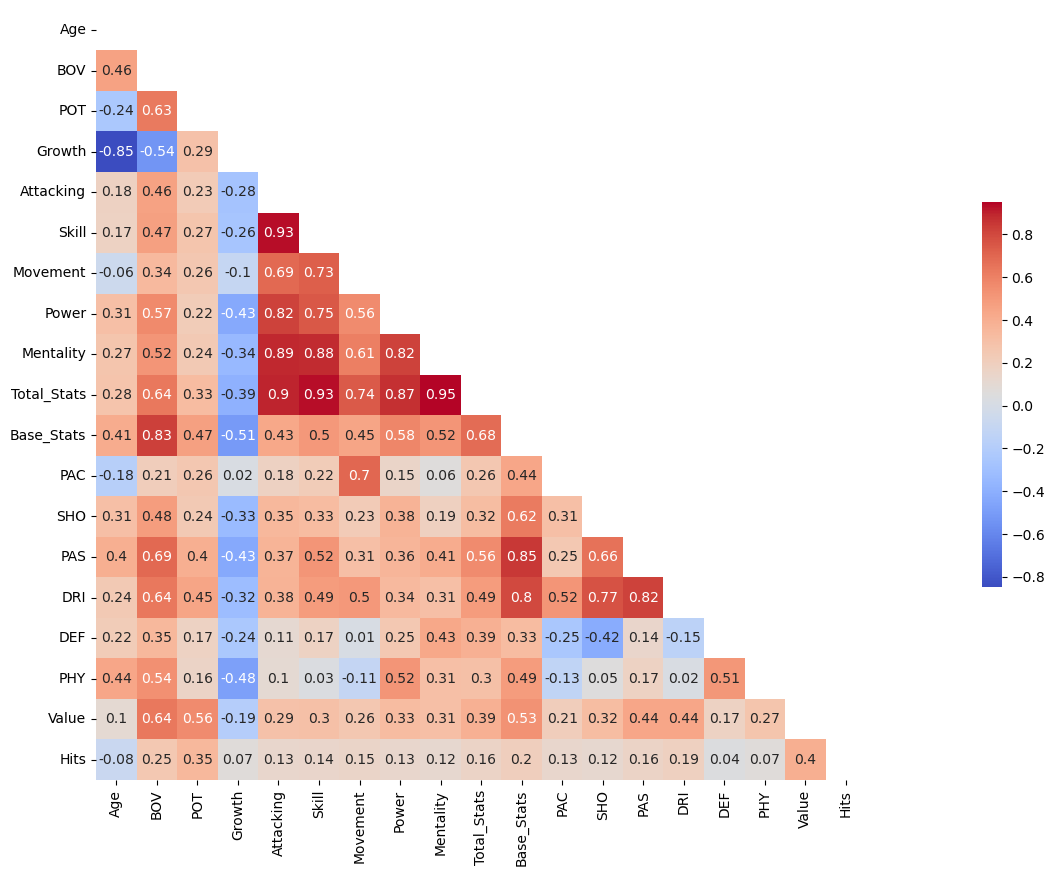

In [19]:
# Check corr again after drop columns

data_corr = num.corr()
correlations_matrix = round(data_corr,2)

mask = np.zeros_like(correlations_matrix)

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True, square=True, cbar_kws={"shrink":.5}, cmap='coolwarm')


In [20]:
"""
Stats vs Total stats --> multicolinearity
Look at Total stats, there're multiple columns that corr > .9 
Therefore, remove Total_stats

""" 

num = num.drop(["Total_Stats"], axis=1)


# Also should drop one of Skill & Attacking but let's keep it for now what it'll do to the model (out of curiousity)

 ### X-y split.

In [21]:
# our group choose BOV (Best Overall Rating) as a target
y = num['BOV']
X = num.drop(['BOV'], axis=1) 
X.head()

,Age,POT,Growth,Attacking,Skill,Movement,Power,Mentality,Base_Stats,PAC,SHO,PAS,DRI,DEF,PHY,Value,Hits
0,33,69,0,313,338,347,347,320,408,71,59,70,71,68,69,625000,4
1,37,71,0,337,369,305,324,362,385,53,69,73,69,58,63,600000,4
2,33,71,0,337,387,295,284,317,354,45,68,76,77,36,52,1100000,11
3,36,82,14,264,255,176,239,271,369,61,66,66,69,47,60,0,3
4,36,81,0,367,408,346,297,370,420,58,70,85,85,63,59,5500000,149


In [22]:
X.shape

(17125, 17)

### Normalize Data

In [23]:
from sklearn.preprocessing import MinMaxScaler

# normalize data (rescale) into (0,1)
transformer = MinMaxScaler().fit(X) 
X_minmax = transformer.transform(X) 

# create new data frame using data from 'x_minmax'
X_normed = pd.DataFrame(X_minmax, columns = X.columns)
X_normed.head() 


,Age,POT,Growth,Attacking,Skill,Movement,Power,Mentality,Base_Stats,PAC,SHO,PAS,DRI,DEF,PHY,Value,Hits
0,0.459459,0.458333,0.037037,0.693069,0.690867,0.666667,0.693038,0.727763,0.666667,0.647887,0.558442,0.661765,0.641791,0.708861,0.636364,0.005924,0.000109
1,0.567568,0.500000,0.037037,0.752475,0.763466,0.547009,0.620253,0.840970,0.581481,0.394366,0.688312,0.705882,0.611940,0.582278,0.545455,0.005687,0.000109
2,0.459459,0.500000,0.037037,0.752475,0.805621,0.518519,0.493671,0.719677,0.466667,0.281690,0.675325,0.750000,0.731343,0.303797,0.378788,0.010427,0.000870
3,0.540541,0.729167,0.555556,0.571782,0.496487,0.179487,0.351266,0.595687,0.522222,0.507042,0.649351,0.602941,0.611940,0.443038,0.500000,0.000000,0.000000
4,0.540541,0.708333,0.037037,0.826733,0.854801,0.663818,0.534810,0.862534,0.711111,0.464789,0.701299,0.882353,0.850746,0.645570,0.484848,0.052133,0.015875


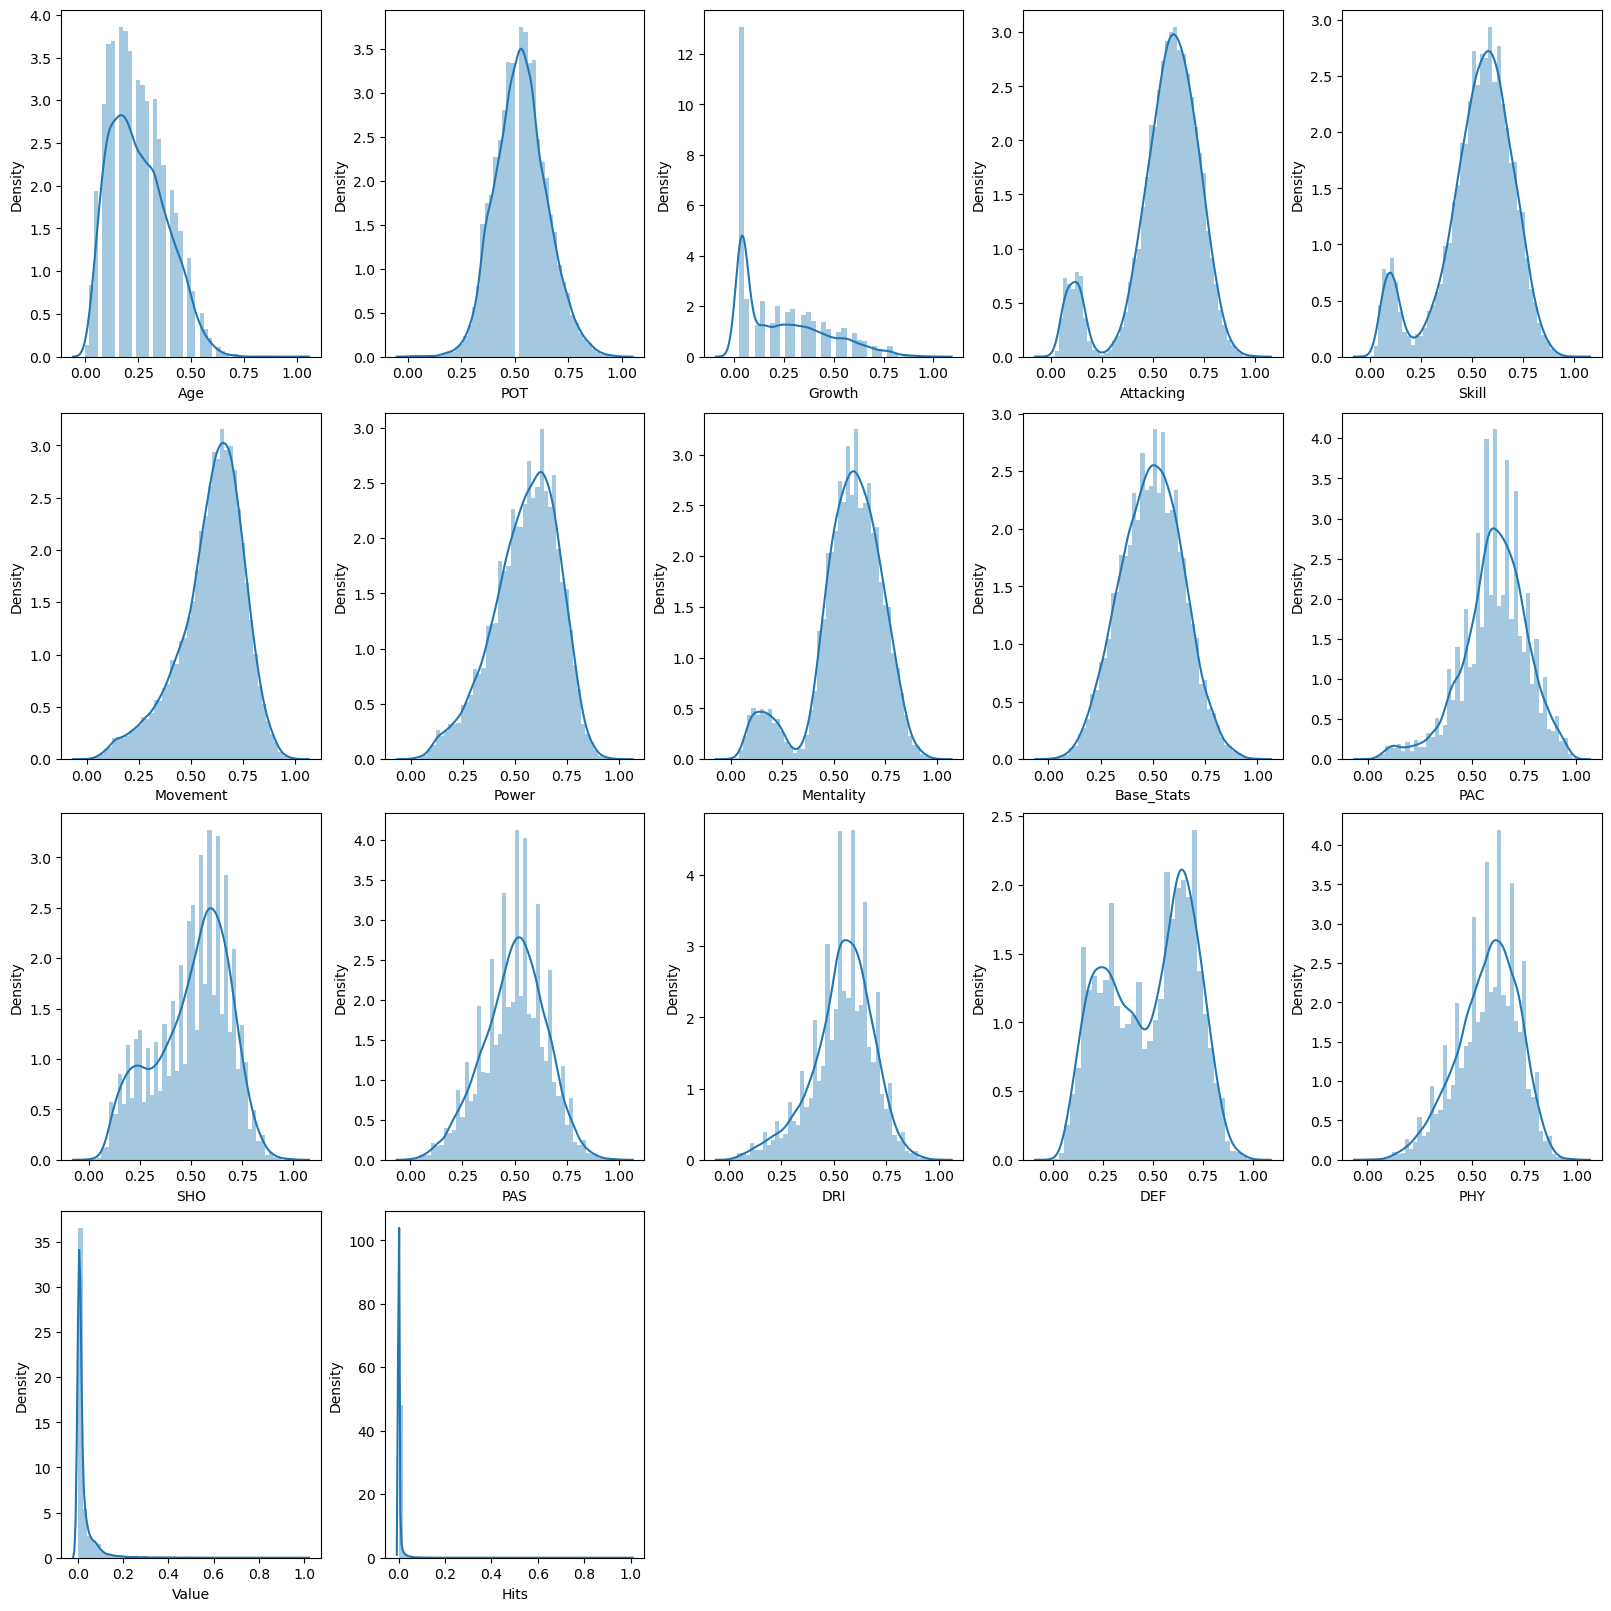

In [24]:
# visualize the distribution after normalization

enum_X = list(enumerate(X_normed, start = 1)) # enumerate adds a counter to an iterable and returns in it as the enumerate objec
                                            # put the enumerate objec into another object (as a list), to be able to reuse again

plt.figure(figsize = (16, 16), constrained_layout = True)

for i in enum_X:
    plt.subplot(4, 5, i[0]) # create multi-plot, using subplot, 4 rows, 5 cols, sequence of plot (iterate through enum_x)
    sns.distplot(X_normed[(i[1])])
    
  

(-456.85, 1000.0)

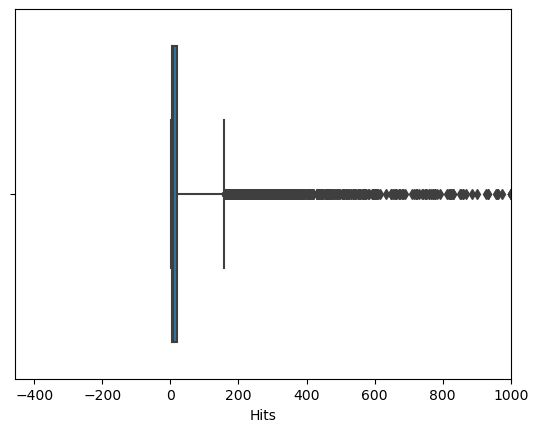

In [25]:
# From correlation & distribution graph >> Hits doesn't look promising for being a good predictor
# Also, its describtive data is not a normal distributed
""" 
count    17125.000000
mean        35.370745
std        158.410068
min          3.000000
25%          4.000000
50%          7.000000 (median)
75%         18.000000
max       9200.000000
Name: Hits, dtype: float64
median 7.0

"""

# Even if we work on outliers, it won't change the majority (see graph below)
sns.boxplot(num["Hits"], whis = 10)
plt.xlim(None, 1000)



In [26]:
# Therefor, remove Hits from our feature
X_normed = X_normed.drop(["Hits"],axis=1)

 ## Preparing Data For Training The Model

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [28]:
# Check categorical data
cat.head()

,BP,Position
0,LWB,LM
1,CM,CM CAM CDM
2,CAM,CAM RM RW LM
3,ST,NaN
4,CAM,CM CAM


In [29]:
# check number of Null in "Position"

cat['Position'].isnull().sum() # Not a lot of Null, comparing to the whole data but I won't use this data for analyse anyway
                                # For now, I'll use BP for analysis

cat = cat.drop(["Position"], axis=1)
cat.nunique()

BP    15
dtype: int64

In [30]:
# Decoding BP

encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(cat)
encoded = encoder.transform(cat).toarray() # transform step = encoding step --> get an array as a result 
cat_encoded = pd.DataFrame(encoded) # put the array into a data frame
cat_encoded.columns = encoder.get_feature_names_out() # name the columns after transformation
cat_encoded.shape

(17125, 14)

In [31]:
# Concat categorical & numerical data (the normalized one) into one data frame, X
X = pd.concat([X_normed, cat_encoded], axis=1)
X.shape


(17125, 30)

In [32]:
X.head()

,Age,POT,Growth,Attacking,Skill,Movement,Power,Mentality,Base_Stats,PAC,SHO,PAS,DRI,DEF,PHY,Value,BP_CB,BP_CDM,BP_CF,BP_CM,BP_GK,BP_LB,BP_LM,BP_LW,BP_LWB,BP_RB,BP_RM,BP_RW,BP_RWB,BP_ST
0,0.459459,0.458333,0.037037,0.693069,0.690867,0.666667,0.693038,0.727763,0.666667,0.647887,0.558442,0.661765,0.641791,0.708861,0.636364,0.005924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.567568,0.500000,0.037037,0.752475,0.763466,0.547009,0.620253,0.840970,0.581481,0.394366,0.688312,0.705882,0.611940,0.582278,0.545455,0.005687,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.459459,0.500000,0.037037,0.752475,0.805621,0.518519,0.493671,0.719677,0.466667,0.281690,0.675325,0.750000,0.731343,0.303797,0.378788,0.010427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.540541,0.729167,0.555556,0.571782,0.496487,0.179487,0.351266,0.595687,0.522222,0.507042,0.649351,0.602941,0.611940,0.443038,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.540541,0.708333,0.037037,0.826733,0.854801,0.663818,0.534810,0.862534,0.711111,0.464789,0.701299,0.882353,0.850746,0.645570,0.484848,0.052133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-test split

In [33]:
# 20% of data --> test set, 80% --> train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#Some checks on splitted data
print("TRAIN GROUP: ", len(X_train))
print("TEST GROUP: ", len(X_test))


TRAIN GROUP:  13700
TEST GROUP:  3425


### Training The Model | Linear Regression

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Predict on Test Set

In [35]:
predictions  = model.predict(X_test)
predictions


array([60.42111621, 67.0538628 , 62.3940525 , ..., 68.46998874,
       72.41511175, 61.89455886])

## Model Validation
##### Metrics:
- R2.
- MSE.
- RMSE.
- MAE.

In [36]:
def validate():
    r2 = round(r2_score(y_test, predictions), 2)
    MSE = round(mean_squared_error(y_test, predictions), 2)
    RMSE = round(mean_squared_error(y_test, predictions, squared=False), 2)
    MAE = round(mean_absolute_error(y_test, predictions), 2)


    print("R^2: ", r2)
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
validate()

R^2:  0.98
MSE:  0.76
RMSE:  0.87
MAE:  0.65


#### Skill & Attacking look like multicolinearity
Remove one column (Attacking) from our feature

In [37]:
# What if we remove attacking
X_attack = X.drop(["Attacking"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_attack, y, test_size=0.2, random_state=42) 

#Some checks on splitted data
print("TRAIN GROUP: ", len(X_train))
print("TEST GROUP: ", len(X_test))

# model fitting
model = LinearRegression()
model.fit(X_train, y_train)
print("MODEL: ", model)

# predict on test data set
predictions  = model.predict(X_test)
predictions

validate()

print("After remove 'Attacking' column, all the prediction metrics stay the same. >> Therefore, drop 'Attacking' in the model")

TRAIN GROUP:  13700
TEST GROUP:  3425
MODEL:  LinearRegression()
R^2:  0.98
MSE:  0.76
RMSE:  0.87
MAE:  0.65
After remove 'Attacking' column, all the prediction metrics stay the same. >> Therefore, drop 'Attacking' in the model


In [38]:
X = X.drop(["Attacking"], axis=1)

In [39]:
# What about Mentality?

X_metality = X.drop(["Mentality"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_metality, y, test_size=0.2, random_state=42) 

#Some checks on splitted data
print("TRAIN GROUP: ", len(X_train))
print("TEST GROUP: ", len(X_test))

# model fitting
model = LinearRegression()
model.fit(X_train, y_train)
print("MODEL: ", model)

# predict on test data set
predictions  = model.predict(X_test)
predictions

validate()

print("After remove 'Mentality' column. Metrics are the same >> We could also drop 'Mentality'")

TRAIN GROUP:  13700
TEST GROUP:  3425
MODEL:  LinearRegression()
R^2:  0.98
MSE:  0.76
RMSE:  0.87
MAE:  0.65
After remove 'Mentality' column. Metrics are the same >> We could also drop 'Mentality'


In [40]:
X = X.drop(["Mentality"], axis=1)

In [41]:
# what valuables are there in the feature now?
X.columns

Index(['Age', 'POT', 'Growth', 'Skill', 'Movement', 'Power', 'Base_Stats',
       'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY', 'Value', 'BP_CB', 'BP_CDM',
       'BP_CF', 'BP_CM', 'BP_GK', 'BP_LB', 'BP_LM', 'BP_LW', 'BP_LWB', 'BP_RB',
       'BP_RM', 'BP_RW', 'BP_RWB', 'BP_ST'],
      dtype='object')

### Check predicted R^2

In [42]:
# Just want to try something here
"""
    I wanted to check if the model is overfit. --> according to this article >> https://statisticsbyjim.com/regression/interpret-adjusted-r-squared-predicted-r-squared-regression/ 
    So I want to calculate predicted-R^2 comparing to R^2 & adjusted-R^2.
    
    I found a script on Stackexchange.com - how to calculate predicted-R^2 --> I don't have time to understand the code here before the presentation. 
    But will study about it later on. For now I just copied & tested it because I wanted to see predicted-R^2.
    
    >> Link to the script: https://stats.stackexchange.com/questions/592653/how-to-get-predicted-r-square-from-statmodels
    
    
"""

import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut


# Split X-y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

pred_rsq_result = []
for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    pred_rsq_result.append(*(y_test - results.predict(X_test)))

pred_rsq = 1 - np.sum(np.square(pred_rsq_result)) / np.var(y) / y.size

# rsquared on all data
model = sm.OLS(y, X)
results = model.fit()


# Print results
print("R^2: ", round(results.rsquared, 2), "Adjusted R^2: ", round(results.rsquared_adj, 2), "Predicted R^2: ", round(pred_rsq, 2))

 
"""According to the Statisticsbyjim article >> 'A predicted R-squared that is distinctly smaller than R-squared is a warning sign that you are overfitting the model.' From this point, our model seems to be a very good. And Jim also mentioned that >> 'To make good predictions, you want Predicted R-squared to be close to the regular R-squared.' """

R^2:  0.98 Adjusted R^2:  0.98 Predicted R^2:  0.98


"According to the Statisticsbyjim article >> 'A predicted R-squared that is distinctly smaller than R-squared is a warning sign that you are overfitting the model.' From this point, our model seems to be a very good. And Jim also mentioned that >> 'To make good predictions, you want Predicted R-squared to be close to the regular R-squared.' "

## Visulaizing Regression Fits

In [43]:
# Split X-y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# apply the model to predict on X_test set
predictions = model.predict(X_test)
predictions.shape

(3425,)

In [44]:
# get predicted result into the DataFrame "results"
results = pd.DataFrame()
results['true'] = y_test
results['pred'] = predictions
results['diff'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results.head()

,true,pred,diff
15195,60,60.456778,0.456778
14193,67,67.051937,0.051937
16722,62,62.417357,0.417357
8037,67,68.635859,1.635859
6350,78,76.645474,1.354526


<AxesSubplot:xlabel='true', ylabel='pred'>

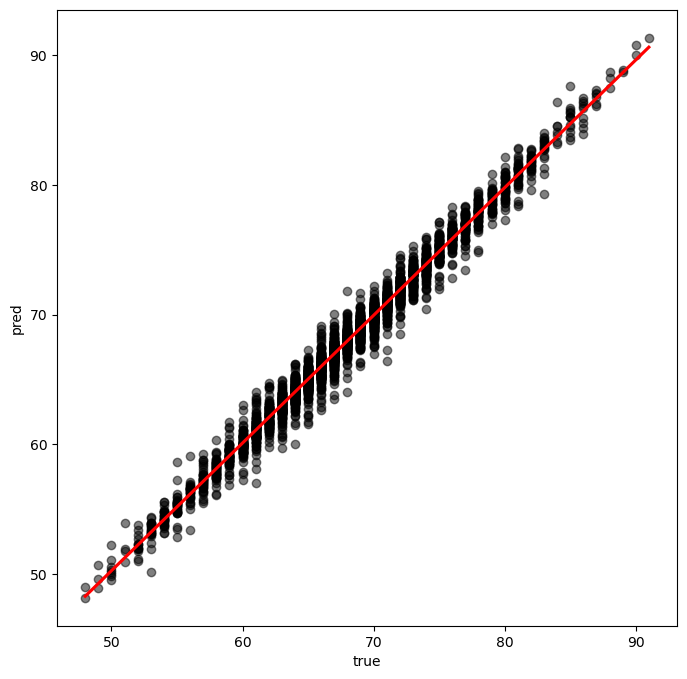

In [45]:
# Initialize layout
fig, ax = plt.subplots(figsize = (8, 8))

# visualize with scatter plot with a regression line

sns.regplot(results['true'], results['pred'], scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

## Preparing Data & Save to CSV

In [46]:
# get cleaned data into csv (for SQLquery) --> undated 10.03.2023 we won't need SQL for this project but still a good idea to save (cleaned) data for further uses.
num_fifa = num_fifa # numerical columns

# get categorical columns
cat2 = categorical.drop(["Gender", "Loan_Date_End", "Player_Photo", "Club_Logo", "Flag_Photo", 
                         "Team_&_Contract", "Loan_Date_End", "Height", "Weight", "Value", "Wage", "Release_Clause"], axis=1)


# concat numerical + categorical data into one data frame
data_fifa = pd.concat([cat2, num_fifa], axis=1)

In [47]:
# save to csv
data_fifa.to_csv("data_fifa.csv")

## Answer Our Group's Question
### Decide the best replacement for a transferred player 

In [48]:

""" 
Our 12 y/o client wants to find the player best fit for CAM (Center Attacking Midfielder) 
to replace his injured player.

He's looking for the player age 30 or below. So that can play for the team for a long run.
"""


# So the first question: who is the best players for CAM position?

top_ten_bov = data_fifa[(data_fifa['BP'] == 'CAM') & (data_fifa["Age"] <= 30)]
top_ten_bov = top_ten_bov.nlargest(10, 'BOV')
top_ten_bov.head(3)

,Name,Nationality,Club,BP,Position,foot,Joined,Contract,W/F,SM,A/W,D/W,IR,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,ID,Age,OVA,BOV,POT,Growth,Attacking,Crossing,Finishing,Heading_Accuracy,Short_Passing,Volleys,Skill,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Movement,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Power,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Mentality,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending,Marking,Standing_Tackle,Sliding_Tackle,Goalkeeping,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,Total_Stats,Base_Stats,PAC,SHO,PAS,DRI,DEF,PHY,Height,Weight,Value,Wage,Release_Clause,Hits
2871,K. De Bruyne,Belgium,Manchester City,CAM,CAM CM,Right,"Aug 30, 2015",2015 ~ 2023,5 ★,4★,High,High,4 ★,406,83+3,83+3,83+3,88+0,88+0,88+0,88+0,88+0,89+2,89+2,89+2,89+2,89+2,89+2,89+2,89+2,79+3,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3,192985,29,91,91,91,0,407,94,82,55,94,82.0,441,88,85.0,83,93,92,398,77,76,78.0,91,76.0,408,91,63.0,89,74,91,408,76,66.0,88.0,94.0,84,91.0,186,68,65,53.0,56,15,13,5,10,13,2304,485,76,86,93,88,64,78,180.34,69.92,87000000,370000,161000000,406
5425,P. Dybala,Argentina,Juventus,CAM,CF CAM,Left,"Jul 1, 2015",2015 ~ 2022,3 ★,4★,Medium,Medium,3 ★,433,83+3,83+3,83+3,87+0,87+0,87+0,87+0,87+0,88+1,88+1,88+1,86+3,82+3,82+3,82+3,86+3,68+3,64+3,64+3,64+3,68+3,64+3,54+3,54+3,54+3,64+3,14+3,211110,26,88,89,89,1,405,82,84,64,87,88.0,436,91,88.0,88,75,94,437,89,82,92.0,84,90.0,382,82,75.0,78,60,87,348,48,42.0,85.0,87.0,86,84.0,120,32,48,40.0,26,5,4,4,5,8,2154,452,85,85,84,92,43,63,177.80,74.91,71000000,190000,122500000,433
9633,J. Sancho,England,Borussia Dortmund,CAM,RM LM CAM,Right,"Aug 31, 2017",2017 ~ 2023,3 ★,5★,High,Medium,3 ★,1.5K,77+3,77+3,77+3,86+0,84+0,84+0,84+0,86+0,86+3,86+3,86+3,85+3,79+3,79+3,79+3,85+3,66+3,62+3,62+3,62+3,66+3,61+3,49+3,49+3,49+3,61+3,19+3,233049,20,87,89,93,6,373,83,81,38,88,83.0,380,92,81.0,48,68,91,435,86,81,91.0,87,90.0,328,70,51.0,77,67,63,313,44,39.0,83.0,87.0,60,84.0,105,32,41,32.0,52,7,11,10,11,13,1986,430,83,74,81,91,37,64,180.34,76.27,69500000,82000,132100000,1500


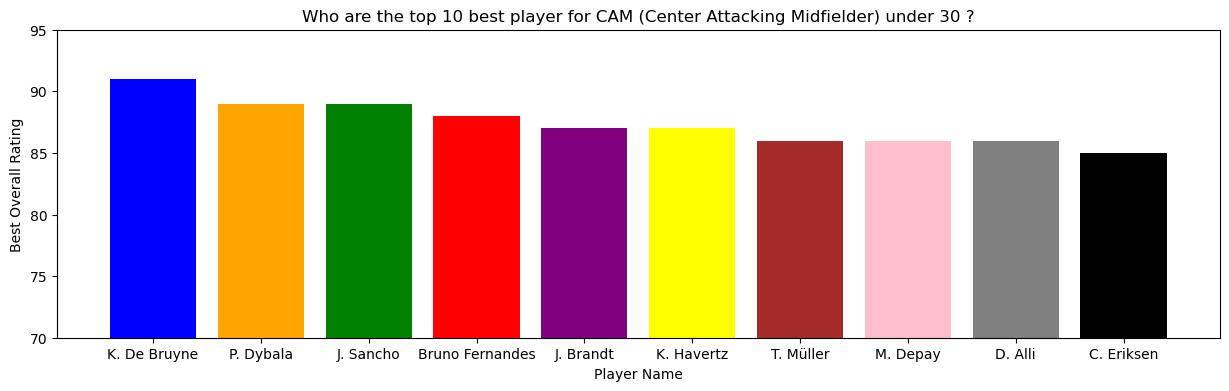

In [49]:
plt.figure(figsize=(15,4))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'gray', 'black']
plt.bar(top_ten_bov['Name'], top_ten_bov['BOV'], color=colors)

plt.xlabel('Player Name')
plt.ylabel('Best Overall Rating')
plt.title('Who are the top 10 best player for CAM (Center Attacking Midfielder) under 30 ?')

# control x and y limits
plt.ylim(70, 95)
plt.xlim(None, None)
plt.show()

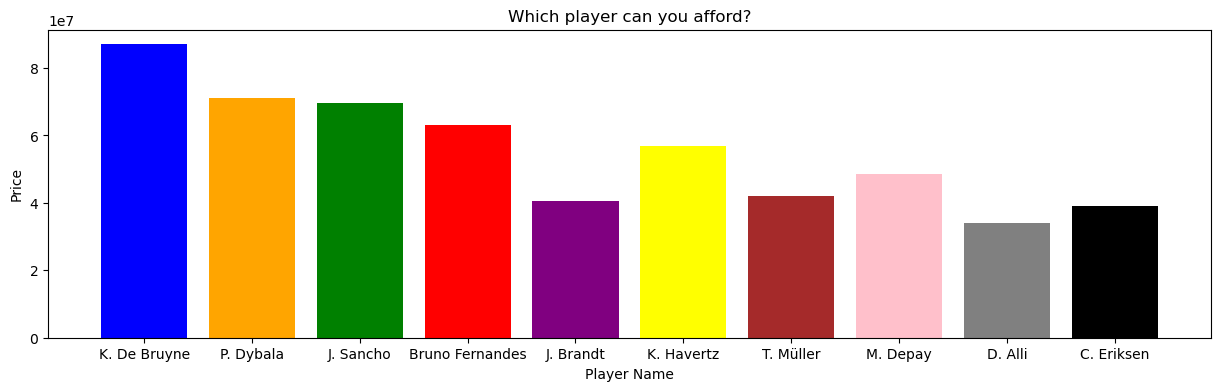

In [50]:
# "That sounds great but can I afford to pay the price?" Our client asked.

plt.figure(figsize=(15,4))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'gray', 'black']
plt.bar(top_ten_bov['Name'], top_ten_bov['Value'], color=colors)

plt.xlabel('Player Name')
plt.ylabel('Price')
plt.title('Which player can you afford?')

# control x and y limits
plt.ylim(None, None)
plt.xlim(None, None)
plt.show()

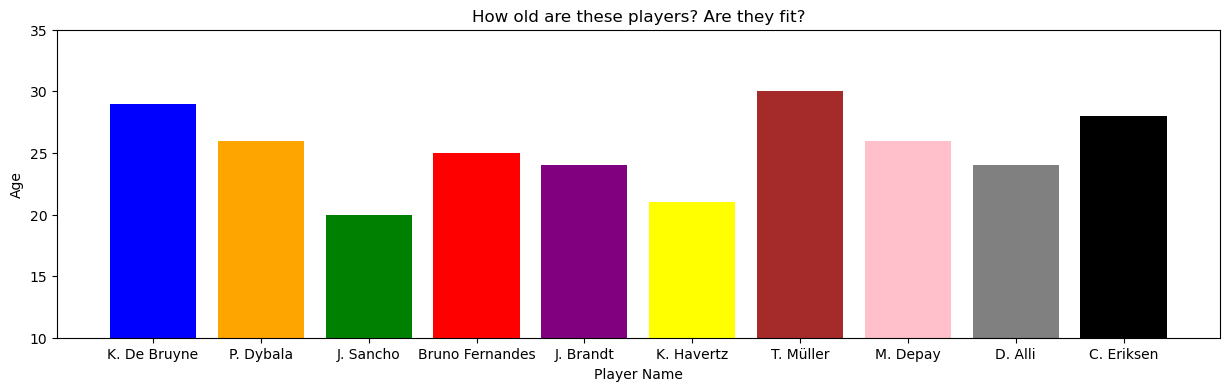

In [51]:
# "I want the youngest but best one, so he can play long and improve overtime. Do you have that?" Our client asked.


plt.figure(figsize=(15,4))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'yellow', 'brown', 'pink', 'gray', 'black']
plt.bar(top_ten_bov['Name'], top_ten_bov['Age'], color=colors)

plt.xlabel('Player Name')
plt.ylabel('Age')
plt.title('How old are these players? Are they fit?')

# control x and y limits
plt.ylim(10, 35)
plt.xlim(None, None)
plt.show()

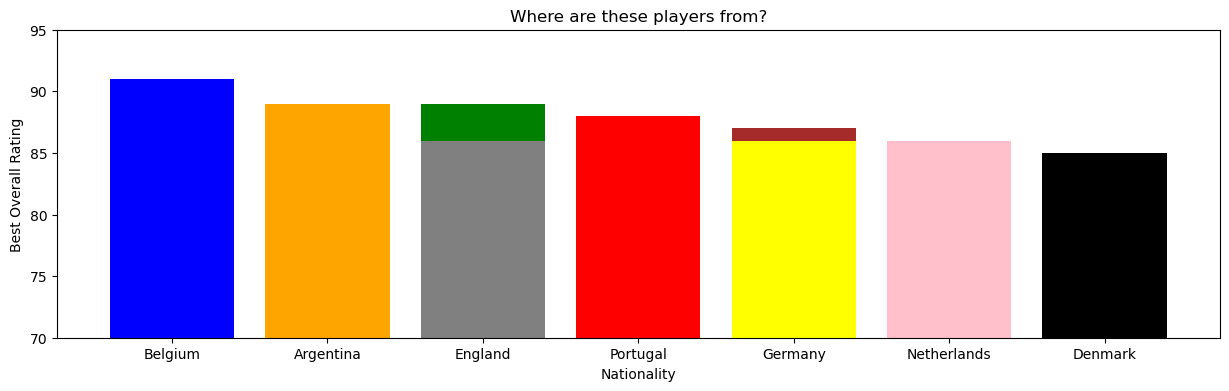

In [52]:
# Nationality?
plt.figure(figsize=(15,4))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'yellow', 'pink', 'gray', 'black']
plt.bar(top_ten_bov['Nationality'], top_ten_bov['BOV'], color=colors)

plt.xlabel('Nationality')
plt.ylabel('Best Overall Rating')
plt.title('Where are these players from?')

# control x and y limits
plt.ylim(70, 95)
plt.xlim(None, None)
plt.show()

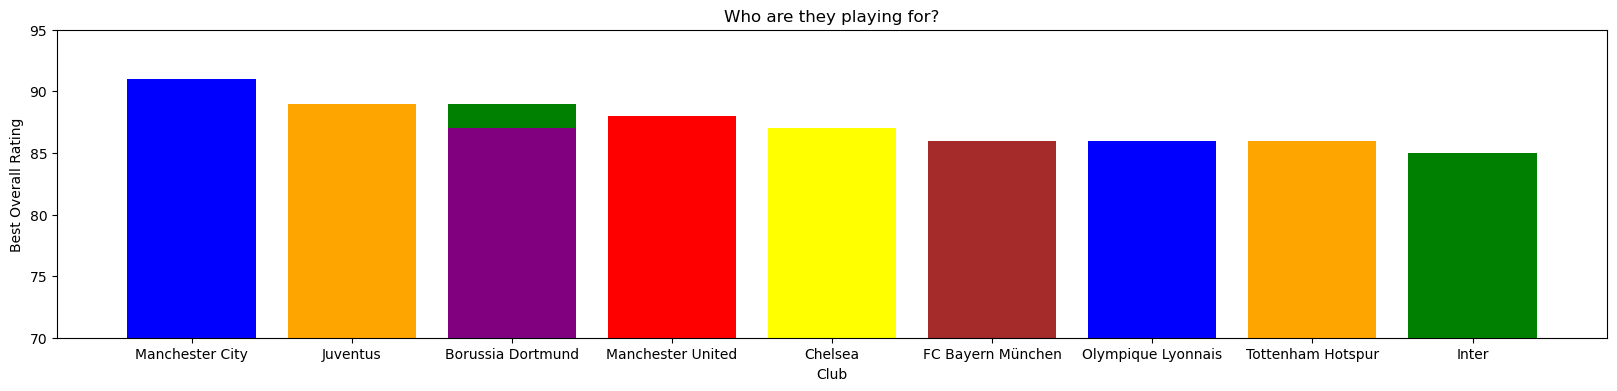

In [53]:
# Who are they playing for?

plt.figure(figsize=(20,4))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'yellow', 'brown']
plt.bar(top_ten_bov['Club'], top_ten_bov['BOV'], color=colors)

plt.xlabel('Club')
plt.ylabel('Best Overall Rating')
plt.title("Who are they playing for?")

# control x and y limits
plt.ylim(70, 95)
plt.xlim(None, None)
plt.show()

### What are their best skills?

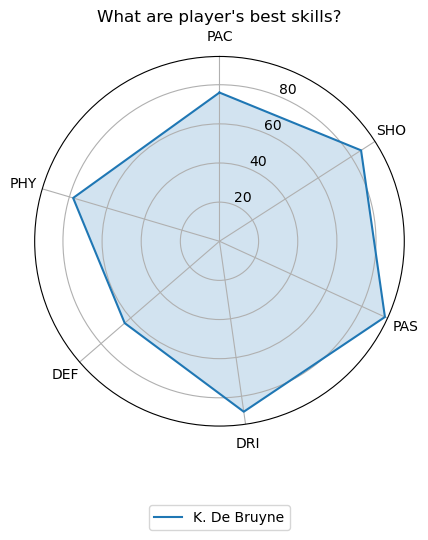

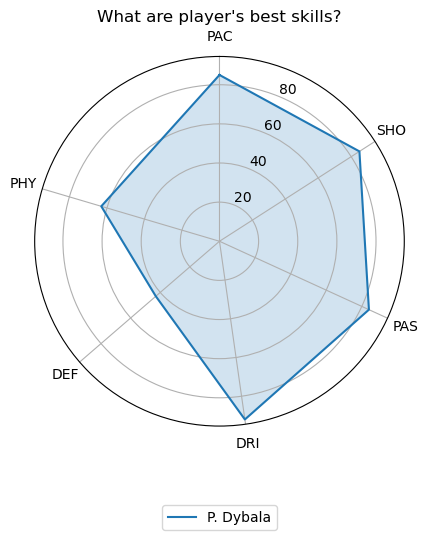

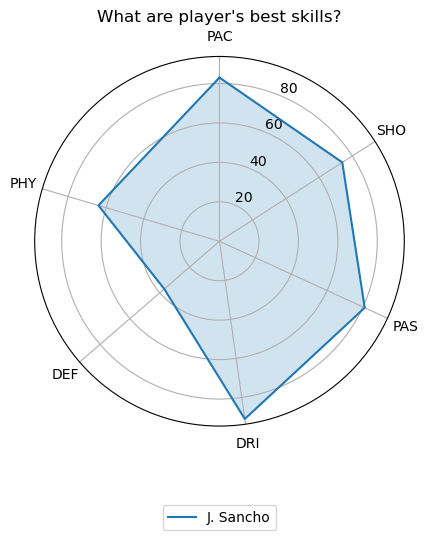

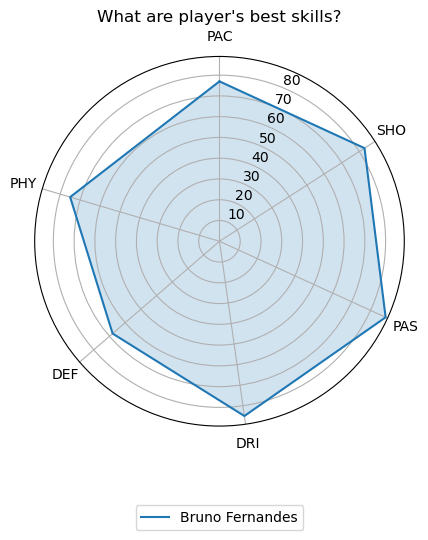

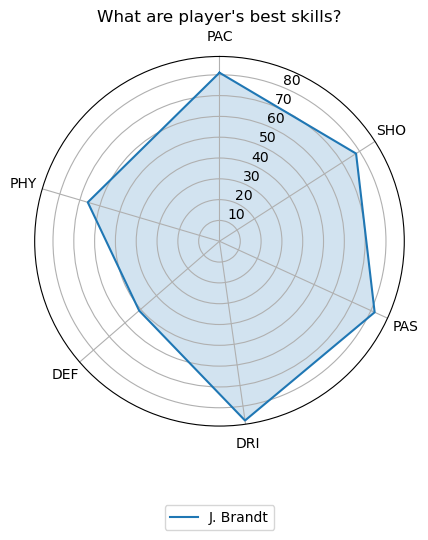

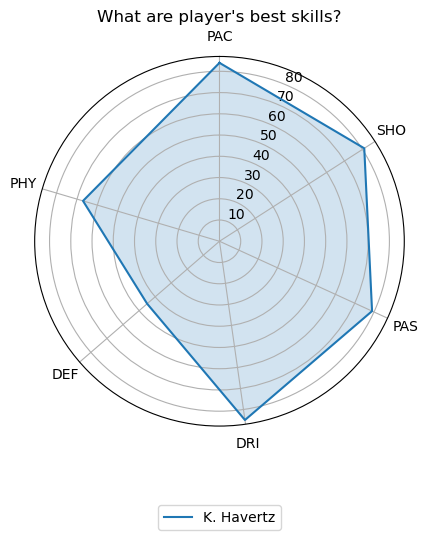

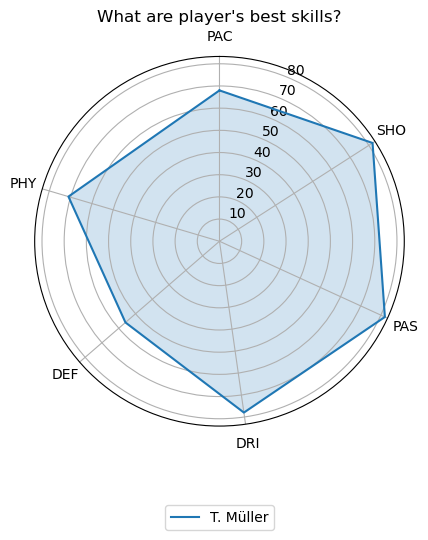

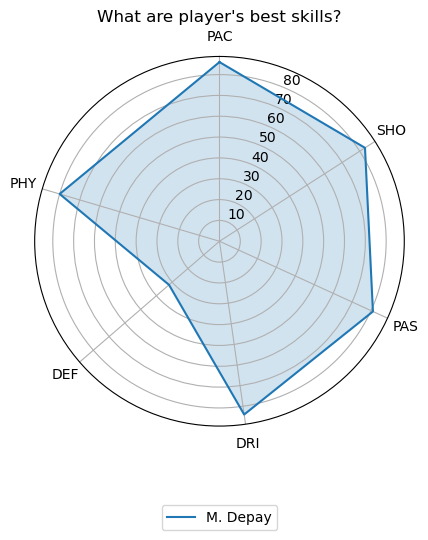

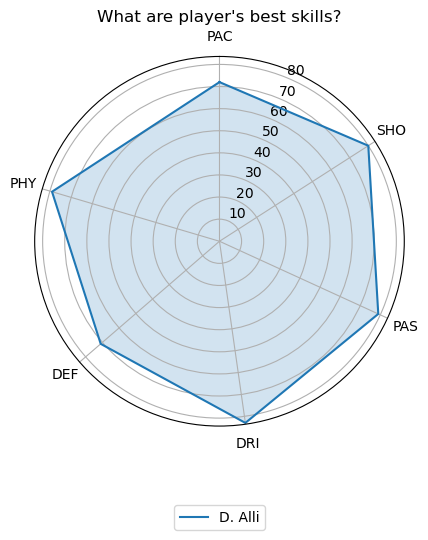

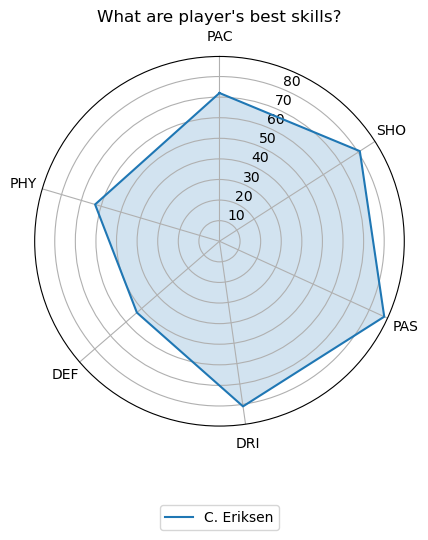

In [54]:
attributes = ["PAC", "SHO", "PAS", "DRI", "DEF", "PHY"]

values = [] 

for i in range (10):
    values.append(list(top_ten_bov[attributes].iloc[i]))
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    ax.set_theta_offset(0.5 * 3.14159)
    ax.set_theta_direction(-1)

    ax.plot(attributes + [attributes[0]], values[i] + [values[i][0]], label=top_ten_bov['Name'].iloc[i])
    ax.fill(attributes + [attributes[0]], values[i] + [values[i][0]], alpha=0.2)


    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5)
    plt.title("What are player's best skills?")
    plt.show()